# E-Communication Classification for Digital Forensics Using Deep Learning

---



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan  7 04:42:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Flow of the notebook

The notebook will be divided into seperate sections as stated below:
1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools and libraries. Details of the tools used are as under.

 - Data: 
	 - We are using our newly created dataset, which we have hosted on the Google Drive: [ECommunication Classification Dataset](https://docs.google.com/spreadsheets/d/1-hZ19AN8A2yb-iT2Fd0dQhYN1YeOcZ7d/edit?usp=share_link&ouid=107491280941988021913&rtpof=true&sd=true)
	 - We are referring only to the Excel (xlsx) file from Google Drive folder
	 - There are `83,067` rows of data divided into 2 columns: 
		 - Text (The actual communication data)  
		 - Class_Label (Class Label)

 - Language Model Used:
	 - We have used DistilBERT as the classifier. It is a smaller transformer model as compared to BERT or Roberta. It is created by process of distillation applied to BERT.
	 - [Research Paper](https://arxiv.org/abs/1910.01108)



 - Script Objective:
	 - The objective of this script is to fine tune DistilBERT to be able to classify the data/text into the following categories:
		 - Normal
		 - Financial Fraud
		 - Hate Speech
		 - Racism
		 - Religious Abuse
		 - Sexual Abuse
		 - Islamophobia
		 - Terrorism/Violence
		 - Political_Abuse

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script.

Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU. 

In [ ]:
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.3 MB/s eta 0:00:00


In [ ]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
import math
import seaborn as sns
import re
import sys
import nltk
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np
import spacy
import string
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import cuda
from google.colab import drive
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
%pip install simple-colors
from simple_colors import *
import warnings
nltk.download('stopwords')
warnings.filterwarnings("ignore")
%pip install simple-colors
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Setting up the device for GPU usage
device = 'cuda' if cuda.is_available() else 'cpu'

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes. 
*Assuming that the `combined_v3.xlsx` is already downloaded/linked in the `Google Drive` folder*

After importing the file in a dataframe and giving it the headers, cleaning the file to remove the unwanted columns and creating an additional column for training.

In [ ]:
drive.mount('/content/drive')
sys.path.insert(0, '/content/mydrive/Thesis/')
%cd /content/drive/My\ Drive/Thesis
!ls

Mounted at /content/drive
/content/drive/My Drive/Thesis
combined_v3.xlsx  DistilBERT.ipynb  NB.ipynb   Test_Dataset.xlsx
combined_v4.xlsx  LSTM.ipynb	    SVM.ipynb


In [ ]:
df=pd.read_excel(r'/content/drive/MyDrive/Thesis/combined_v3.xlsx')
df['Text'].isnull().sum()
df=df.dropna() # deleting the empty not available columns 
print(df.dropna().index)
df.isnull().sum()
print(df.head())

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            83057, 83058, 83059, 83060, 83061, 83062, 83063, 83064, 83065,
            83066],
           dtype='int64', length=83067)
                                                Text      Class_Label
0  to unsubscribe send mail to majordomo URL with...  Financial_Fraud
1   special offer free trial hyperlink click here...  Financial_Fraud
2   this URL email is sponsored by thinkgeek welc...  Financial_Fraud
3   volume 1 issue 1 sept 1 hyperlink click here ...  Financial_Fraud
4  don t miss out on an amazing business opportun...  Financial_Fraud


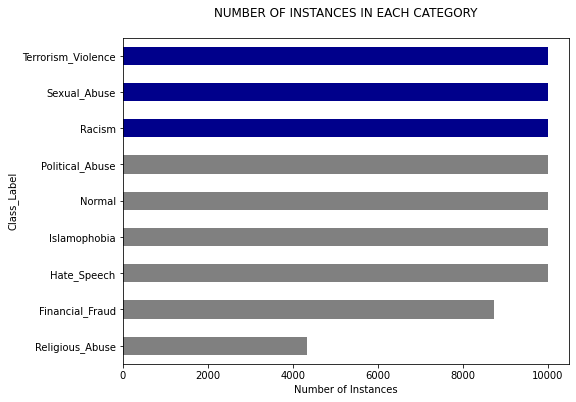

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df.groupby('Class_Label').Text.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF INSTANCES IN EACH CATEGORY\n')
plt.xlabel('Number of Instances', fontsize = 10);

In [ ]:
df.sample(frac=1)
df = shuffle(df)
df = shuffle(df)
df = shuffle(df)
df.head()

,Text,Class_Label
31079,content - length : 2121 university of brighton...,Normal
52306,after the dark chocolate duckling incident i w...,Racism
7151,"Hurricane Katrina, Hurricane Wilma and South A...",Financial_Fraud
59218,No one will believe that lie which u are talki...,Religious_Abuse
19876,"You may be talking about Indian muslim, trust ...",Islamophobia


In [ ]:
STOPWORDS = set(stopwords.words('english'))

In [ ]:
#new data preprocessing
#Lower Casing
#It is the most common and simplest text preprocessing technique. Applicable to most text mining and NLP problems. The main goal is to convert the text into the lower casing so that ‘apple’, ‘Apple’ and ‘APLE’ are treated the same way.
# Lower Casing --> creating new column called text_lower
df['text_lower']  = df['Text'].str.lower()
df['text_lower'].head()

#Removal of Punctuations, creating a new column called 'text_punct]'
df['text_punct'] = df['text_lower'].str.replace('[^\w\s]','')
df['text_punct'].head()

#Stop-word removal, 
#Stop words are a set of commonly used words in a language. Examples of stop words in English are “a”, “we”, “the”, “is”, “are” and etc. The idea behind using stop words is that, by removing low information words from text, we can focus on the important words instead. We can either create a custom list of stopwords ourselves (based on use case) or we can use predefined libraries.
#Importing stopwords from nltk library
STOPWORDS = set(stopwords.words('english'))
# Function to remove the stopwords
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Applying the stopwords to 'text_punct' and store into 'text_stop'
df["text_stop"] = df["text_punct"].apply(stopwords)
df["text_stop"].head()

#Common word removal
#We can also remove commonly occurring words from our text data First, let’s check the 10 most frequently occurring words in our text data.
# Checking the first 10 most frequent words
cnt = Counter()
for text in df["text_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

#Spelling Correction
#Social media data always messy data and it has spelling mistakes. Hence, spelling correction is a useful pre-processing step because this will help us to avoid multiple words. Example, “text” and “txt” will be treated as different words even if they are used in the same sense. This can be done by textblob library
# Spell check using text blob for the first 5 records
df['text_stop'][:5].apply(lambda x: str(TextBlob(x).correct()))

#removing numbers
#df['text_stop'] = ''.join(c for c in df['text_stop'] if not c.isdigit())
df['Text_Number']= df['text_stop'].str.replace('\d+', '')
df.head()

,Text,Class_Label,text_lower,text_punct,text_stop,Text_Number
31079,content - length : 2121 university of brighton...,Normal,content - length : 2121 university of brighton...,content length 2121 university of brighton ...,content length 2121 university brighton uk lan...,content length university brighton uk languag...
52306,after the dark chocolate duckling incident i w...,Racism,after the dark chocolate duckling incident i w...,after the dark chocolate duckling incident i w...,dark chocolate duckling incident concerned bun...,dark chocolate duckling incident concerned bun...
7151,"Hurricane Katrina, Hurricane Wilma and South A...",Financial_Fraud,"hurricane katrina, hurricane wilma and south a...",hurricane katrina hurricane wilma and south as...,hurricane katrina hurricane wilma south asia e...,hurricane katrina hurricane wilma south asia e...
59218,No one will believe that lie which u are talki...,Religious_Abuse,no one will believe that lie which u are talki...,no one will believe that lie which u are talki...,one believe lie u talking muslims attacking hi...,one believe lie u talking muslims attacking hi...
19876,"You may be talking about Indian muslim, trust ...",Islamophobia,"you may be talking about indian muslim, trust ...",you may be talking about indian muslim trust m...,may talking indian muslim trust idiots pakista...,may talking indian muslim trust idiots pakista...


In [ ]:
# # Removing unwanted columns and only leaving title of news and the category which will be the target
df = df[['Text_Number','Class_Label']]
df.rename(columns = {'Text_Number':'Text'}, inplace = True)
df.head()

,Text,Class_Label
31079,content length university brighton uk languag...,Normal
52306,dark chocolate duckling incident concerned bun...,Racism
7151,hurricane katrina hurricane wilma south asia e...,Financial_Fraud
59218,one believe lie u talking muslims attacking hi...,Religious_Abuse
19876,may talking indian muslim trust idiots pakista...,Islamophobia


In [ ]:
# # Converting the codes to appropriate categories using a dictionary
my_dict = {
    'Normal':'0',
    'Financial_Fraud':'1',
    'Hate_Speech':'2',
    'Racism':'3',
    'Religious_Abuse':'4',
    'Sexual_Abuse':'5',
    'Islamophobia':'6',
    'Terrorism_Violence':'7',
    'Political_Abuse':'8'
}

def update_cat(x):
    return my_dict[x]

df['Class_Label'] = df['Class_Label'].apply(lambda x: update_cat(x))

encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['Class_Label'].apply(lambda x: encode_cat(x))

In [ ]:
df.head(10)

,Text,Class_Label,ENCODE_CAT
31079,content length university brighton uk languag...,0,0
52306,dark chocolate duckling incident concerned bun...,3,1
7151,hurricane katrina hurricane wilma south asia e...,1,2
59218,one believe lie u talking muslims attacking hi...,4,3
19876,may talking indian muslim trust idiots pakista...,6,4
42409,mimirocah cnn liberalcunts manners standards s...,8,5
50851,shawty wanna tell secrets rap niggah tell bitc...,3,1
64108,yaboytosh dad eyes redson smoked weed daddad d...,5,6
53393,palominito realdonaldtrump hhsgov data deport ...,3,1
4059,microsoft office pro microsoft word microsof...,1,2


<a id='section03'></a>
### Preparing the Dataset and Dataloader

We will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. We will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing. 
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network.

#### *Triage* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the DistilBERT model for training. 
- We are using the DistilBERT tokenizer to tokenize the data in the `Text` column of the dataframe. 
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`
- `target` is the encoded category on the news headline. 
- The *Triage* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training. 

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [ ]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 12
VALID_BATCH_SIZE = 3
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        text = str(self.data.Text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [ ]:
# Creating the dataset and dataloader for the neural network
train_size = 0.80
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (83067, 3)
TRAIN Dataset: (66454, 3)
TEST Dataset: (16613, 3)


In [ ]:
sizetrain_dataset = len(train_dataset.axes[0])
print ("Train Dataset Size: ",sizetrain_dataset)
sizetest_dataset = len(test_dataset.axes[0])
print ("Test Dataset Size: ",sizetest_dataset)
noofstepstrain = math.ceil(sizetrain_dataset/TRAIN_BATCH_SIZE)
print (color.BOLD,"Number of steps per epoch in Training: ",noofstepstrain, color.END)
noofstepstest = math.ceil(sizetrain_dataset/VALID_BATCH_SIZE)
print (color.BOLD,'Number of steps per epoch in Testing: ', noofstepstest, color.END)

Train Dataset Size:  66454
Test Dataset Size:  16613
 Number of steps per epoch in Training:  5538 
 Number of steps per epoch in Testing:  22152 


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `DistillBERTClass`. 
 - This network will have the DistilBERT Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs. 
 - The data will be fed to the DistilBERT Language model as defined in the dataset. 
 - Final layer outputs is what will be compared to the `encoded category` to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output. 
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
#Model layers and structure/architecture
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 9)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [ ]:
#information of each layer of the neural network
model = DistillBERTClass()
model.to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

In [ ]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Fine Tuning the Model

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), an epoch defines how many times the complete data will be passed through the network. 

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size. 
- Subsequent output from the model and the actual category are compared to calculate the loss. 
- Loss value is used to optimize the weights of the neurons in the network.
- After a set number of steps the loss value is printed in the console.

In [ ]:
# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# Defining the Early Stopping Function
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            print('Counter: ', self.counter)
            self.counter += 1
            if self.counter >= self.patience:
                
                return True
        return False
# Defining the training function on the 80% of the dataset for tuning the distilbert model
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)
        
        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        displaytrainsteps = math.ceil(noofstepstrain/5)
        if _%displaytrainsteps==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per {displaytrainsteps} steps: {loss_step}")
            print(f"Training Accuracy per {displaytrainsteps} steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(color.BOLD,f'The Total Accuracy for Epoch {epoch+1} of {EPOCHS}: {(n_correct*100)/nb_tr_examples}',color.END)
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_loss

In [ ]:
EPOCHS = 9
early_stopper = EarlyStopper(patience=3, min_delta=0.001)
for epoch in range(EPOCHS):
  epoch_loss = train(epoch)
  if early_stopper.early_stop(epoch_loss):   
    print('LOSS: ', epoch_loss)
    print('Early stopped at epoch: ', epoch+1)          
    break

Training Loss per 1108 steps: 2.1806697845458984
Training Accuracy per 1108 steps: 8.333333333333334
Training Loss per 1108 steps: 0.8405238791386537
Training Accuracy per 1108 steps: 74.00811541929666
Training Loss per 1108 steps: 0.621340724182965
Training Accuracy per 1108 steps: 81.01789204630883
Training Loss per 1108 steps: 0.527326005479895
Training Accuracy per 1108 steps: 83.93734335839599
Training Loss per 1108 steps: 0.4728450667287019
Training Accuracy per 1108 steps: 85.52522746071133
 The Total Accuracy for Epoch 1 of 9: 86.78785325187347 
Training Loss Epoch: 0.4312008826478135
Training Accuracy Epoch: 86.78785325187347
Training Loss per 1108 steps: 0.09829700738191605
Training Accuracy per 1108 steps: 100.0
Training Loss per 1108 steps: 0.20775346567214367
Training Accuracy per 1108 steps: 93.51517883979561
Training Loss per 1108 steps: 0.2053479118042457
Training Accuracy per 1108 steps: 93.58743046158473
Training Loss per 1108 steps: 0.20137468335393788
Training Accur

<a id='section06'></a>
# **Validating the Model**

During the validation stage we pass the unseen data (Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data is the **20%** of of the main dataset which was seperated during the Dataset creation stage.

During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

In [ ]:
def valid(model, testing_loader):
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    y_pred = []
    y_true = []
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            # print(outputs, targets)
            # loss = loss_function(outputs, targets)
            # tr_loss += loss.item()
            try:
               big_val, big_idx = torch.max(outputs.data, dim=1)
               n_correct += calcuate_accu(big_idx, targets)
               y_pred = y_pred + list(big_idx.to('cpu').numpy())
               y_true = y_true + list(targets.to('cpu').numpy())
            except:
              print('EXCEPT BLOCK')
              print(outputs, targets)
              print(nb_tr_steps)
              print(nb_tr_examples)
            # n_correct += accuracy_score(big_idx.to('cpu').numpy(), targets.to('cpu').numpy())
            
            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            displayteststeps = math.ceil(noofstepstest/5)

            if _%displayteststeps==0:
                # loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                # print(f"Validation Loss per 200 steps: {loss_step}")
                print(f"Validation Accuracy per {displayteststeps} steps: {accu_step}")
    # epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    # print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu, y_pred, y_true

In [ ]:
print('This is the validation section to print the accuracy and see how it performs by leveraging on the dataloader created for the validation dataset, the approach is using more of pytorch')
acc, y_pred, y_true = valid(model, testing_loader)
print(color.BOLD,"Accuracy on test data = %0.2f%%" % acc,color.END)

This is the validation section to print the accuracy and see how it performs by leveraging on the dataloader created for the validation dataset, the approach is using more of pytorch
Validation Accuracy per 4431 steps: 100.0
Validation Accuracy per 4431 steps: 94.01323706377858
Validation Accuracy Epoch: 94.04081141274905
 Accuracy on test data = 94.04% 


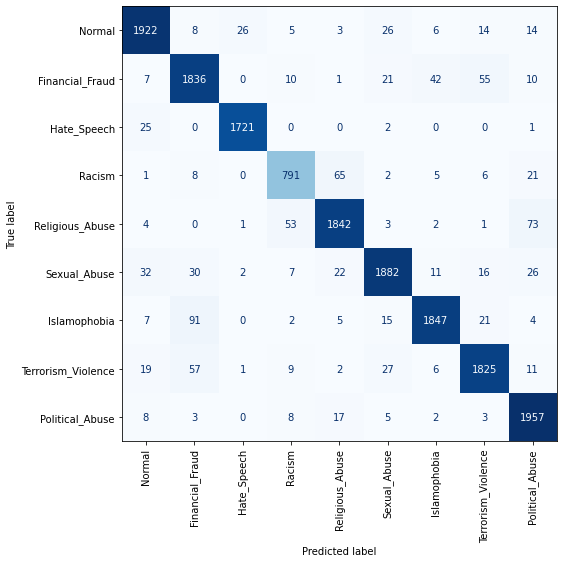

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize='all')
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=list(my_dict.keys()), xticks_rotation="vertical",
    ax=ax, colorbar=False, cmap="Blues")
#more color maps (cmap) at: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# default color: YlGnBu

In [ ]:
report_dict = classification_report(y_true, y_pred, output_dict=True)
pd.DataFrame(report_dict).T

,precision,recall,f1-score,support
0,0.949136,0.949605,0.949370,2024.000000
1,0.903099,0.926337,0.914570,1982.000000
2,0.982867,0.983991,0.983429,1749.000000
3,0.893785,0.879867,0.886771,899.000000
4,0.941237,0.930773,0.935976,1979.000000
5,0.949067,0.928008,0.938419,2028.000000
6,0.961478,0.927209,0.944033,1992.000000
7,0.940237,0.932550,0.936378,1957.000000
8,0.924421,0.977034,0.950000,2003.000000
accuracy,0.940408,0.940408,0.940408,0.940408


Confusion matrix

<a id='section07'></a>
### Saving the Trained Model:

The model and its vocabulary are saved locally. These files are can be used in the future to make inference on new inputs of communication data.

In [ ]:
# Saving the files for re-use

output_model_file = F"/content/drive/My Drive/Thesis/model_DistilBERT.bin"
output_vocab_file = F"/content/drive/My Drive/Thesis/vocab_DistilBERT.bin"

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
